# Test of the path-shadowing using the SPX index data

### Importing necessary libraries

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.neighbors import KernelDensity

from shadowing import (
    Softmax,
    compute_smile,
    PathShadowing,
    Foveal,
    RelativeMSE,
    PredictionContext,
    ArrayType,
)

import warnings
warnings.filterwarnings('ignore')  # Display all warnings

### Generating and analyzing different data sets
#### SPX index data

[*********************100%%**********************]  1 of 1 completed


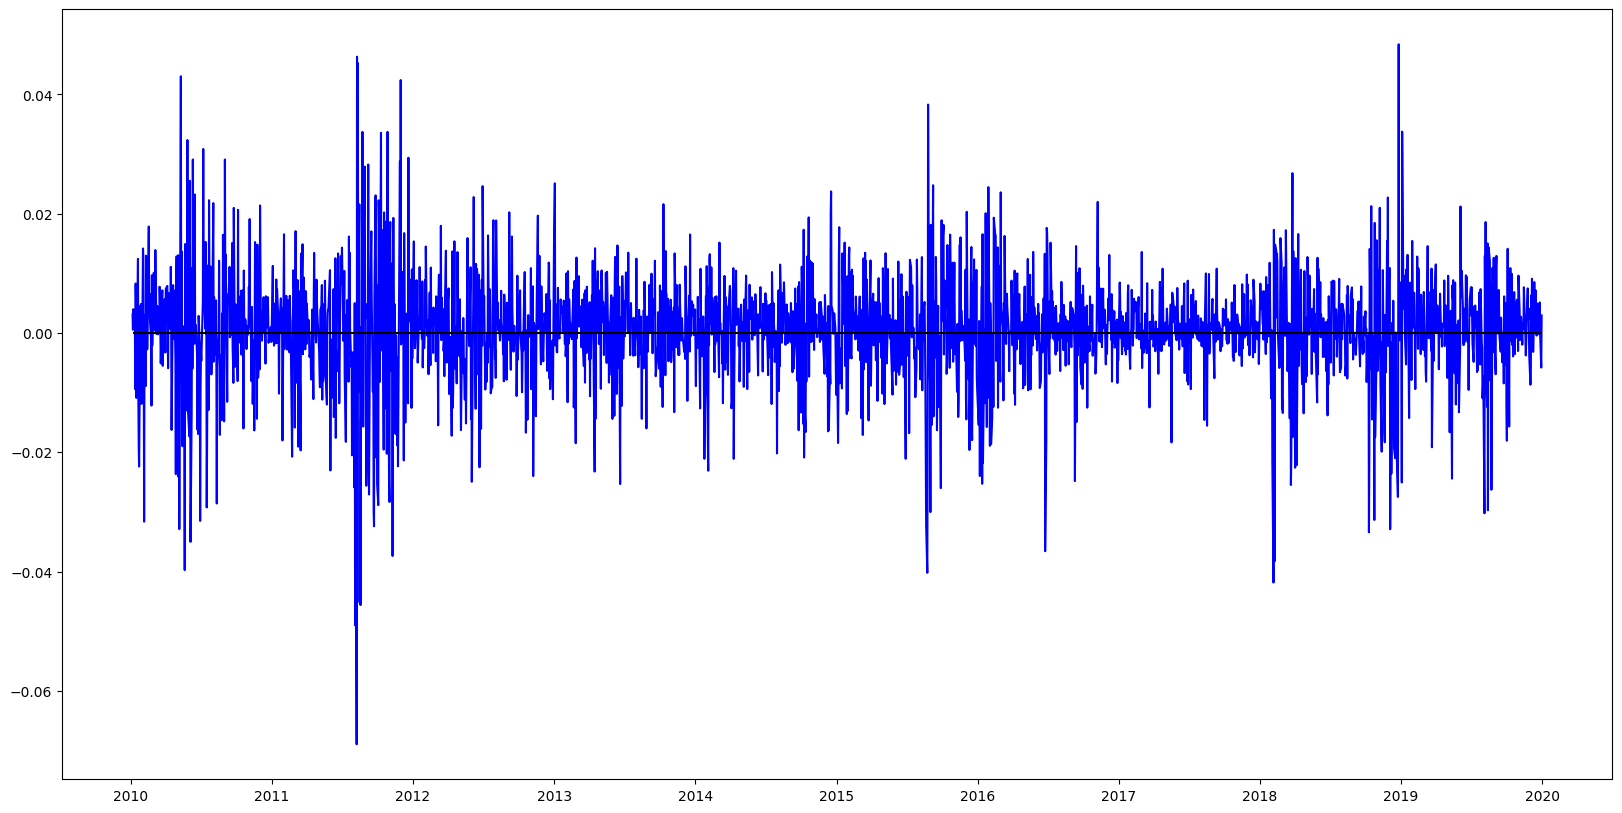

In [35]:
#importing SPX data from yahoo finance from 2010 to 2020
spx = yf.download('^GSPC','2010-01-01','2020-01-01')
#log returns of the adjusted close price
spx['log_returns'] = np.log(spx['Adj Close']/spx['Adj Close'].shift(1))
#removing the first row with NaN
spx = spx.iloc[1:]
#plotting the log returns
plt.figure(figsize=(20,10))
plt.plot(spx['log_returns'], color='blue')
plt.hlines(y=0, xmin=spx.index[0], xmax=spx.index[-1], color='black')

**Standard statics of log-returns in the SPX index observed in the period 2000-2019**

In [36]:
#standard statistics of the log returns
spx['log_returns'].describe()

count    2515.000000
mean        0.000417
std         0.009317
min        -0.068958
25%        -0.003272
50%         0.000593
75%         0.005029
max         0.048403
Name: log_returns, dtype: float64

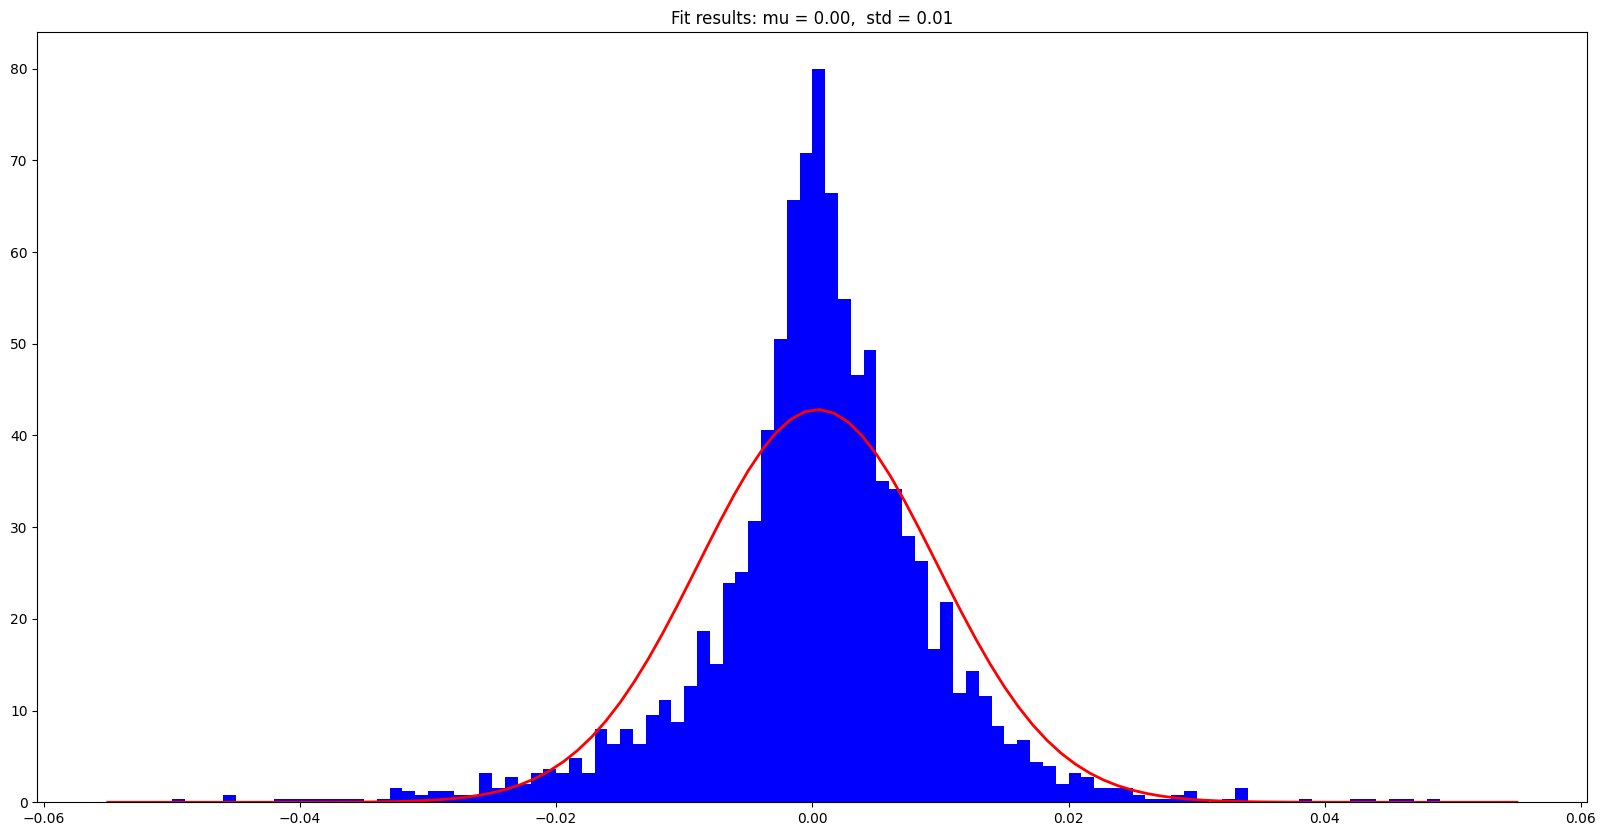

In [37]:
#histogram of the log returns with xmin and xmax between -0.05 and 0.05
plt.figure(figsize=(20,10))
plt.hist(spx['log_returns'], bins=100, density=True, color='blue', range=(-0.05,0.05))
#fit a gaussian distribution to the log returns and plot it
mu, std = norm.fit(spx['log_returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color='red')
plt.title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))
plt.show()

As expected the distribution of the log-prices of the SPX Index are not normal. 

## Path Shadowing on SPX Index 

We assume that the real world is at least approximatevly
stationary, in the sense that it can be approximated by a
statistical model with fixed, time-independent parameters.

In [44]:
#Testing the stationarity of the log returns

#ADF test
from statsmodels.tsa.stattools import adfuller
result_ADF = adfuller(spx['log_returns'])
print('ADF Statistic: %f' % result_ADF[0])
print('ADF p-value: %f' % result_ADF[1])

#KPSS test
from statsmodels.tsa.stattools import kpss
result_KPSS = kpss(spx['log_returns'])
print('KPSS Statistic: %f' % result_KPSS[0])
print('KPSS p-value: %f' % result_KPSS[1])
p_value_kpss = result_KPSS[1]
if p_value_kpss <= 0.05:
    print("The log-prices may not be stationary.")
else:
    print("The log-prices are likely stationary.")

ADF Statistic: -11.376637
ADF p-value: 0.000000
KPSS Statistic: 0.023579
KPSS p-value: 0.100000
The log-prices are likely stationary.


Given the past history $x_{past}$ at current
time t, a model-free method for predicting the unknown future
$x_{future}$ is to look for occurrences similar to $x_{past}$ in the historical
realization of log-prices. If such occurrences can be found,
what happened thereafter provides some information about the
unknown future $x_{future}$  at the current time t.

But finding exact occurrences of course happens with vanishing
probability.

**Path Shadowing**:
We introduce an embedding $h(\tilde{x}_{past})$
that reduces the dimensionality of past trajectories and define shadowing paths as paths $x$ whose past history $h(x_{past})$ is close to $h(\tilde{x}_{past})$ in a certain sense. 
With: 
- $\tilde{x}_{past}$ : representing the current past history 
- $x_{past}$ : representing the scanned paths. 
Such path $x_{past}$ *shadow* $\tilde{x}_{past}$, i.e they provide insights on the future. 

**Path Shadowing Monte-Carlo**
The shadowing paths are used as inputs for the proposed Monte-Carlo method. The method is based on the idea of generating a large number of shadowing paths and then using them to estimate the distribution of the future $x_{future}$ at the current time t.

So for a quantity $q(x_{future})$ of interest, the optimal estimate of $q(\tilde{x}_{future})$ for the mean square error as a function of the observed past history $\tilde{x}_{past}$ is given by the conditional expectation:
$$
E[q(x) | {x}_{past} = \tilde{x}_{past}]
$$
where $E$ is the expectation under the true distribution $p(x)$ of log-prices.

**The goal** is to estimate the conditional expectation using the Monte-Carlo method. The idea is to generate a large number of shadowing paths and then use them to estimate the conditional expectation. 

**The Monte-Carlo method**:
The Monte Carlo method estimates the conditional expectation by averaging the quantity of interest over a large number of shadowing paths.
1. Generate a large number of shadowing paths $x^1, x^2, ..., x^N$.
2. For each path $x_i$, compute the quantity of interest $q(x^i)$.
3. The estimate of the conditional expectation is then given by the sample mean:
$$
\frac{1}{N} \sum_{i=1}^{N} q(x^i)
$$
which converges to the true conditional expectation as the number of shadowing paths goes to infinity.

**The problem**: 
The Monte-Carlo method is computationally expensive, as it requires generating a large number of shadowing paths. It requires a large number of paths $x^i$ such that $x^k_{past} = \tilde x_{past}$ which is impossible for data of finite size.

**Solution**: We consider paths $x$ whose past $x_{past}$ is close to $\tilde x_{past}$ in a certain sense. To tackle this problem, we relax strict conditioning on $\tilde x_{past}$ and consider paths x whose past $x_{past}$ is close to $\tilde x_{past}$ in a certain sense. 
In order to account for possible long-range dependencies, we would like to consider a long past $\tilde x_{past}$. However, finding paths $x_{past}$ at a given distance from $\tilde x_{past}$ becomes exponentially difficult as the size of the path grows : this is the curse of dimensionality. In order to control the dimension, we consider a path embedding $h(x_{past}) \in R^M$. Given a threshold $\eta > 0$ we define the set of *$\eta$-shadowing paths* as
$$ H_{\eta}(\tilde x_{past}) = \{ x \in R^N: || h(x_{past}) - h(\tilde x_{past}) || \leq \eta \}$$

The idea is for a certain small $\eta$, paths in $H_{\eta}(\tilde x_{past})$ can be considered as true realizations of the process that can be used faithfully compute observables. 

### Path Shadowing Monte-Carlo:
Th Monte-Carlo method on shadowing paths is a predective method that uses the past history of the log-prices to estimate the future log-prices. So it is a **predictive method**.

All paths do not have the same weights, unlike the traditional Monte-Carlo method, since $|| h(x_{past}^k) - h(\tilde x_{past}) ||$ is not uniform in k. The weights are given by the distance between the past history of the path and the observed past history. 

It gives the following estimator: 
$$\frac{1}{n} \sum_{k=1}^{n} w_{k}q(x^k)$$
where $w_k$ represents the weight which is called the "Nadaraya–Watson estimator" of the path $x^k$.

We can choose Gaussian weights such that: 
$$w_k = c exp\lbrack-\frac{|| h(x_{past}^k) - h(\tilde x_{past}) ||}{2\eta^2}\rbrack$$

So the set of shadowing path can be defined as: **the set of all paths that are one standard deviation away from the observed past history $\tilde x_{past}$ for the Gaussian kernel**.




# Volatility Prediction using Path Shadowing Monte-Carlo

**Prediction of the future realized volatility over T days:**
$$q_T(x) = \frac{252}{T} \sum_{u=t+1}^{t+T} |\delta x_u|^2$$
for different values of T.

For our analysis, we will consider *T = 1, 7, 25, 75 and 150 days*.

### Path Shadowing
Using observed log-returns of the SPX Index during the year 2022, we identify the most similar paths within the generated dataset.

##### 1. Embedding function
To do this we use an **embedding function $h$** that leverages the scale invariance of the log-returns in the same way of the Scattering Spectra framework.

The function $h$ depends on two parameters $\alpha$ and $\beta$. 

We test first using the same parameters as those used in the tutorial found in Github repository of the authors of the paper; which are $\alpha = 1.15$ and $\beta = 0.9$. But in our context we look at the whole year in the observed past. 

In [3]:
# embedding for dimensionality reduction
embedding = Foveal(
    alpha=1.15,  # cover the past at exponential speed
    beta=0.9,  # look with a weight power-law decay of 0.9
    max_context=252,  # look at half-year in the observed past
)

**Mesure of distance:**
We use the RMSE as a measure of distance between the observed past history and the past history of the paths. 

In [4]:
# distance between embedded paths
distance = RelativeMSE()